# Installation and Repository cloning

In [30]:
#!pip install adversarial-robustness-toolbox -U
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
#!pip install git+https://github.com/RobustBench/robustbench.git
#!pip install matplotlib
#!pip install pillow
#!pip install foolbox

## Import Libraries

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

import time
import matplotlib.pyplot as plt
import numpy as np

from art.estimators.classification import PyTorchClassifier
import json
import foolbox as fb

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load and Prepare CIFAR-10 Dataset

In [33]:
def load_dataset(dataset_split):
    # Load CIFAR-10 dataset using torchvision
    transform = transforms.Compose([
      transforms.ToTensor(),
                                 ])
    testset = datasets.CIFAR10(root='./data/cifar', train=False, download=True, transform=transform)

    # Truncated testset for experiments and ablations
    if isinstance(dataset_split, int):
        testset, _ = torch.utils.data.random_split(testset,
                                                          [dataset_split, len(testset) - dataset_split],
                                                          generator=torch.Generator().manual_seed(42))
    
    # Extract data and labels from torchvision dataset
    xtest = torch.stack([data[0] for data in testset])
    ytest = torch.tensor([data[1] for data in testset])

    return xtest, ytest

## Load and Prepare Adversarial Model

In [34]:
from robustbench.utils import load_model

model_name = 'Sehwag2021Proxy_R18'
net = load_model(model_name=model_name, dataset='cifar10', threat_model='L2')
net = torch.nn.DataParallel(net)

net.eval()
net.to(device)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

# Initialize PyTorchClassifier for ART toolbox as a wrapper
art_net = PyTorchClassifier(model=net,
                               loss=criterion,
                               optimizer=optimizer,
                               input_shape=(3, 32, 32),
                               nb_classes=10,
                               device_type=device,
                               clip_values=(0.0, 1.0))
fb_net = fb.PyTorchModel(net, bounds=(0.0, 1.0), device=device)

/home/shao/anaconda3/envs/art/lib/python3.12/site-packages/robustbench/utils.py:165: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_lo

## Function to Test Model Accuracy

In [35]:
def test_accuracy(model, xtest, ytest):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for i in range(len(xtest)):
            x = xtest[i].unsqueeze(0).to(device)
            y = ytest[i].unsqueeze(0).to(device)

            outputs = model(x)
            _, predicted = torch.max(outputs, 1)

            total += y.size(0)
            correct += (predicted==y).sum().item()

    accuracy = (correct / total) * 100
    print(f'\nAccuracy of the testset is: {accuracy:.3f}%\n')

## Adversarial Attacks

In [36]:
from art.attacks.evasion import (FastGradientMethod,
                                 ProjectedGradientDescentPyTorch,
                                 AutoProjectedGradientDescent,
                                 AutoAttack,
                                 CarliniL2Method,
                                 DeepFool,
                                 ElasticNet)
from adversarial_attack.exp_attack import ExpAttack
from autoattack import AutoAttack as original_AutoAttack

In [37]:
class AdversarialAttacks:
  def __init__(self, art_net, net, epsilon, eps_iter, norm, max_iterations_fast_attacks, max_iterations_slow_attacks):
    self.art_net = art_net
    self.epsilon = epsilon
    self.eps_iter = eps_iter
    self.norm = norm
    self.max_iterations_fast_attacks = max_iterations_fast_attacks
    self.max_iterations_slow_attacks = max_iterations_slow_attacks
    self.net = net

  def init_attacker(self, attack_type, **kwargs):
    if attack_type=='fast_gradient_method':
        return FastGradientMethod(self.art_net,
                                eps=self.epsilon,
                                eps_step=self.epsilon,
                                norm=self.norm,
                                **kwargs)
    elif attack_type=='projected_gradient_descent':
        return ProjectedGradientDescentPyTorch(self.art_net,
                                             eps=self.epsilon,
                                             eps_step=self.eps_iter,
                                             max_iter=self.max_iterations_fast_attacks,
                                             norm=self.norm,
                                             **kwargs)
    elif attack_type=='pgd_early_stopping':
        return ProjectedGradientDescentPyTorch(self.art_net,
                                             eps=self.epsilon,
                                             eps_step=self.eps_iter,
                                             max_iter=1,
                                             norm=self.norm,
                                             **kwargs)
    elif attack_type=='ART_AutoAttack':
        return AutoAttack(estimator=self.art_net,
                        eps=self.epsilon,
                        eps_step=self.eps_iter,
                        norm=self.norm)
    elif attack_type=='original_AutoAttack':
        return original_AutoAttack(net, 
                                   norm='L1', 
                                   eps=self.epsilon,
                                   device=device)
    elif attack_type=='auto_projected_gradient_descent':
        return AutoProjectedGradientDescent(estimator=self.art_net,
                                          eps=self.epsilon,
                                          eps_step=self.eps_iter,
                                          norm=self.norm,
                                          max_iter=self.max_iterations_fast_attacks,
                                          **kwargs)
    elif attack_type=='brendel_bethge':
        return fb.attacks.L1BrendelBethgeAttack(steps=self.max_iterations_fast_attacks)
    elif attack_type=='carlini_wagner_l2':
        return CarliniL2Method(self.art_net,
                               max_iter=self.max_iterations_slow_attacks,
                               **kwargs)
    elif attack_type=='deep_fool':
        return DeepFool(self.art_net,
                      max_iter=self.max_iterations_fast_attacks,
                      epsilon=self.eps_iter,
                      **kwargs)
    elif attack_type=='elastic_net':
        return ElasticNet(self.art_net,
                      max_iter=self.max_iterations_slow_attacks)
    elif attack_type=='elastic_net_L1_rule':
        return ElasticNet(self.art_net,
                      max_iter=self.max_iterations_slow_attacks,
                      decision_rule='L1')
    elif attack_type=='elastic_net_L1_rule_higher_beta':
        return ElasticNet(self.art_net,
                      max_iter=self.max_iterations_slow_attacks,
                      decision_rule='L1',
                      beta=0.01)
    elif attack_type=='exp_attack':
        return ExpAttack(self.art_net,
                      max_iter=self.max_iterations_slow_attacks,learning_rate=0.1)
    else:
        raise ValueError(f'Attack type "{attack_type}" not supported!')

## Plug-in Function for Adversarial Attack with Early Stopping

In [38]:
def attack_with_early_stopping(art_net, x, y, PGD_iterations, attacker):
    label_flipped = False

    for j in range(PGD_iterations):
        adv_inputs = attacker.generate(x, y.numpy(), verbose=False)

        outputs = art_net.predict(adv_inputs)
        _, predicted = torch.max(torch.tensor(outputs).data, 1)
        label_flipped = bool(predicted.item() != int(y.item()))

        if label_flipped:
            print(f'\tIterations for successful iterative attack: {j+1}')
            break
        
        x = adv_inputs.copy()
            
    return adv_inputs

## Function for Adversarial Distance calculation (attack methods)

In [39]:
def calculation(art_net, fb_net, net, xtest, ytest, epsilon, eps_iter, norm, max_iterations_slow_attacks, max_iterations_fast_attacks, attack_type, verbose: bool = False):

    distance_list, runtime_list = [], []
    art_net.model.to(device)
    net.to(device)
    
    xtest = xtest.to(device)
    ytest = ytest.to(device)
    
    attacks = AdversarialAttacks(art_net=art_net,
                                 net = net,
                          epsilon=epsilon,
                          eps_iter=eps_iter,
                          norm=norm,
                          max_iterations_fast_attacks=max_iterations_fast_attacks,
                          max_iterations_slow_attacks=max_iterations_slow_attacks)
    attacker = attacks.init_attacker(attack_type)

    robust_predictions = 0
    attack_successes = 0
    clean_correct = 0

    for i, x in enumerate(xtest):

        x = x.unsqueeze(0)
        y = ytest[i].unsqueeze(0)
        outputs = art_net.predict(x.cpu())
        
        _, clean_predicted = torch.max(torch.tensor(outputs).data, 1)
            
        if int(clean_predicted.item()) != int(y.item()):
            print('Misclassified input. Not attacking.')
            distance_list.append(False)
            runtime_list.append(False)
            continue        

        clean_correct += 1

        start_time = time.time()

        if attack_type == 'pgd_early_stopping':
            x_adversarial = attack_with_early_stopping(art_net=art_net,
                                                                x=x.numpy(),
                                                                y=y,
                                                                PGD_iterations=max_iterations_fast_attacks,
                                                                attacker=attacker)
            x_adversarial = torch.from_numpy(x_adversarial)
        elif attack_type == 'brendel_bethge':
            _, x_adversarial, _ = attacker(fb_net, x, y, epsilons=[epsilon])
            x_adversarial = x_adversarial[0]
        elif attack_type == 'original_AutoAttack':
            x_adversarial = attacker.run_standard_evaluation(x, y)
            x_adversarial = x_adversarial
        else:             
            x_adversarial = attacker.generate(x.cpu().numpy(), y.cpu().numpy())
            x_adversarial = torch.from_numpy(x_adversarial)
        
        end_time = time.time()
        runtime = end_time - start_time
        runtime_list.append(runtime)

        # Adversarial accuracy calculation
        output_adversarial = art_net.predict(x_adversarial)
        _, predicted_adversarial = torch.max(torch.tensor(output_adversarial).data, 1)

        # Adversarial distance calculation: if no AE found, save epsilon as distance, otherwise save the distance
        if int(predicted_adversarial.item()) == int(y.item()):
            robust_predictions += 1
            distance = epsilon
            distance_list.append(distance)
            if verbose:
                print(f'Image {i}: No adversarial example found.')
        else:
            distance = torch.norm((x.cpu() - x_adversarial), p=float(norm))
            robust_predictions += (round(distance.item(), 2) > epsilon) 
            attack_successes += (round(distance.item(), 2) <= epsilon) 
            distance_list.append(min(distance.item(), epsilon)) #appending epsilon if distance of adversarial example is higher

        if verbose:
            print(f'Image {i}\t\tAdversarial_distance: {distance:.5f}\t\tRuntime: {runtime:5f} seconds')
        if (i + 1) % 20 == 0:
            print(f'{i+1} images done. Current Adversarial Accuracy: {robust_predictions/(i+1)}%')

    adversarial_accuracy = (robust_predictions / len(xtest)) * 100
    attack_success_rate = (attack_successes / clean_correct) * 100
    print(f'\nAdversarial accuracy: {adversarial_accuracy}%\n')

    return distance_list, runtime_list, adversarial_accuracy, attack_success_rate

## Parameters

In [40]:
norm = 1  # 1, 2, np.inf
max_iterations_fast_attacks = 100
max_iterations_slow_attacks = 20
eps_iter = 0.15
epsilon = 12

## Load the dataset

In [41]:
splitsize = 50      # full, int: splitsize
xtest, ytest = load_dataset(dataset_split=splitsize)

Files already downloaded and verified


## Test Accuracy

In [42]:
test_accuracy(net, xtest, ytest)


Accuracy of the testset is: 92.000%



# Experiments

In [49]:
attack_types = [#'fast_gradient_method', #bounded-full
                #'projected_gradient_descent', #bounded-full
                #'pgd_early_stopping', #not-bounded
                #'auto_projected_gradient_descent', #bounded-full
                #'deep_fool', #not-bounded
                #'brendel_bethge', #bounded-min
                #'carlini_wagner_l2', #not-bounded
                'elastic_net', #not-bounded
                'exp_attack'
                #'elastic_net_L1_rule', #not-bounded
                #'elastic_net_L1_rule_higher_beta', #not-bounded
                #'ART_AutoAttack', #bounded-full
                #'original_AutoAttack', #bounded-full
                ]

results_dict = {}

for attack_type in attack_types:
    results_dict[attack_type] = {}
    print(f'\t\t-------------------------- Processing Attack: {attack_type} --------------------------\n')
    results_dict[attack_type]["adversarial_distance"], results_dict[attack_type]["runtime"], results_dict[attack_type]["adversarial_accuracy"] , results_dict[attack_type]["attack_success_rate"] = calculation(
                                                        art_net=art_net,
                                                        fb_net=fb_net,
                                                        net = net,
                                                        xtest=xtest,
                                                        ytest=ytest,
                                                        epsilon=epsilon,
                                                        eps_iter=eps_iter,
                                                        norm=norm,
                                                        max_iterations_fast_attacks=max_iterations_fast_attacks,
                                                        max_iterations_slow_attacks=max_iterations_slow_attacks,
                                                        attack_type=attack_type,
                                                        verbose=True)
    
    mean_value = np.mean([x for x in results_dict[attack_type]["adversarial_distance"] if x is not None])

    print(f'\nMean adversarial distance for {attack_type}: {mean_value:.5f} with total runtime: {sum(results_dict[attack_type]["runtime"]): .5f} seconds\n')

		-------------------------- Processing Attack: elastic_net --------------------------



EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 0		Adversarial_distance: 18.76273		Runtime: 2.620018 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 1		Adversarial_distance: 45.88801		Runtime: 2.185593 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 2		Adversarial_distance: 40.51119		Runtime: 2.188929 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 3		Adversarial_distance: 16.51859		Runtime: 2.182781 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 4		Adversarial_distance: 0.40278		Runtime: 2.222449 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 5		Adversarial_distance: 28.52687		Runtime: 2.197325 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 6		Adversarial_distance: 30.73975		Runtime: 2.198542 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 7		Adversarial_distance: 42.84634		Runtime: 2.188111 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 8		Adversarial_distance: 12.68231		Runtime: 2.123276 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 9		Adversarial_distance: 9.78339		Runtime: 2.121660 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 10		Adversarial_distance: 121.25687		Runtime: 2.155868 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 11		Adversarial_distance: 22.01854		Runtime: 2.170887 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 12		Adversarial_distance: 26.18356		Runtime: 2.776088 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 13		Adversarial_distance: 14.89736		Runtime: 2.159180 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 14		Adversarial_distance: 9.48830		Runtime: 2.143027 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 15		Adversarial_distance: 21.42817		Runtime: 2.157540 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 16		Adversarial_distance: 1.09927		Runtime: 2.180003 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 17		Adversarial_distance: 84.38370		Runtime: 2.165265 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 18		Adversarial_distance: 18.18106		Runtime: 2.159821 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 19		Adversarial_distance: 77.92236		Runtime: 2.178541 seconds
20 images done. Current Adversarial Accuracy: 0.8%


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 20		Adversarial_distance: 96.46809		Runtime: 2.170455 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 21		Adversarial_distance: 29.99060		Runtime: 2.160649 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 22		Adversarial_distance: 31.78030		Runtime: 2.137705 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 23		Adversarial_distance: 52.55913		Runtime: 2.166260 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 24		Adversarial_distance: 20.80176		Runtime: 2.150175 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 25		Adversarial_distance: 50.61469		Runtime: 2.194616 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 26		Adversarial_distance: 36.64978		Runtime: 2.178929 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 27		Adversarial_distance: 73.94171		Runtime: 2.781658 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 28		Adversarial_distance: 24.97411		Runtime: 2.146193 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 29		Adversarial_distance: 21.44945		Runtime: 2.188264 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 30		Adversarial_distance: 62.19590		Runtime: 2.182755 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 31		Adversarial_distance: 22.07111		Runtime: 2.156983 seconds
Misclassified input. Not attacking.


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 33		Adversarial_distance: 49.52811		Runtime: 2.158007 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 34		Adversarial_distance: 40.95591		Runtime: 2.190694 seconds
Misclassified input. Not attacking.


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 36		Adversarial_distance: 57.87490		Runtime: 2.204654 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 37		Adversarial_distance: 74.44584		Runtime: 2.249141 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 38		Adversarial_distance: 1.51644		Runtime: 2.162320 seconds
Misclassified input. Not attacking.


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 40		Adversarial_distance: 19.44263		Runtime: 2.151235 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 41		Adversarial_distance: 19.47954		Runtime: 2.158873 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 42		Adversarial_distance: 5.04188		Runtime: 2.201142 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 43		Adversarial_distance: 65.79270		Runtime: 2.224771 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 44		Adversarial_distance: 12.36467		Runtime: 2.161006 seconds
Misclassified input. Not attacking.


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 46		Adversarial_distance: 31.10025		Runtime: 2.756235 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 47		Adversarial_distance: 28.11652		Runtime: 2.172234 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 48		Adversarial_distance: 36.67910		Runtime: 2.188884 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 49		Adversarial_distance: 39.59521		Runtime: 2.179050 seconds

Adversarial accuracy: 80.0%


Mean adversarial distance for elastic_net: 10.14664 with total runtime:  102.24779 seconds

		-------------------------- Processing Attack: exp_attack --------------------------



EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 0		Adversarial_distance: 16.78459		Runtime: 2.287194 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 1		Adversarial_distance: 31.53563		Runtime: 2.273005 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 2		Adversarial_distance: 36.74889		Runtime: 2.293496 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 3		Adversarial_distance: 13.42530		Runtime: 2.272757 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 4		Adversarial_distance: 0.50766		Runtime: 2.279683 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 5		Adversarial_distance: 26.48469		Runtime: 2.297925 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 6		Adversarial_distance: 32.08025		Runtime: 2.326196 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 7		Adversarial_distance: 39.27121		Runtime: 2.306390 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 8		Adversarial_distance: 9.42306		Runtime: 2.274142 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 9		Adversarial_distance: 4.93811		Runtime: 2.331770 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 10		Adversarial_distance: 109.21053		Runtime: 2.962282 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 11		Adversarial_distance: 15.62037		Runtime: 2.368848 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 12		Adversarial_distance: 18.92637		Runtime: 2.392217 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 13		Adversarial_distance: 11.21451		Runtime: 2.375170 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 14		Adversarial_distance: 8.05117		Runtime: 2.333849 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 15		Adversarial_distance: 14.82006		Runtime: 2.334670 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 16		Adversarial_distance: 0.88611		Runtime: 2.358215 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 17		Adversarial_distance: 91.51284		Runtime: 2.321078 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 18		Adversarial_distance: 11.60711		Runtime: 2.303079 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 19		Adversarial_distance: 79.46445		Runtime: 2.305549 seconds
20 images done. Current Adversarial Accuracy: 0.65%


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 20		Adversarial_distance: 107.34562		Runtime: 2.342846 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 21		Adversarial_distance: 34.82541		Runtime: 2.314651 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 22		Adversarial_distance: 33.81799		Runtime: 2.374257 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 23		Adversarial_distance: 50.43379		Runtime: 2.383921 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 24		Adversarial_distance: 20.09329		Runtime: 2.929670 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 25		Adversarial_distance: 60.94764		Runtime: 2.373045 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 26		Adversarial_distance: 39.37207		Runtime: 2.320559 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 27		Adversarial_distance: 71.18996		Runtime: 2.346037 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 28		Adversarial_distance: 25.03890		Runtime: 2.343585 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 29		Adversarial_distance: 23.83126		Runtime: 2.276005 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 30		Adversarial_distance: 63.53609		Runtime: 2.239706 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 31		Adversarial_distance: 16.55295		Runtime: 2.277039 seconds
Misclassified input. Not attacking.


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 33		Adversarial_distance: 35.61771		Runtime: 2.334288 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 34		Adversarial_distance: 32.07717		Runtime: 2.352526 seconds
Misclassified input. Not attacking.


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 36		Adversarial_distance: 36.71127		Runtime: 2.394036 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 37		Adversarial_distance: 102.66656		Runtime: 2.359509 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 38		Adversarial_distance: 1.37320		Runtime: 2.378784 seconds
Misclassified input. Not attacking.


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 40		Adversarial_distance: 25.21938		Runtime: 2.350603 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 41		Adversarial_distance: 14.81778		Runtime: 2.983994 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 42		Adversarial_distance: 4.44691		Runtime: 2.319488 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 43		Adversarial_distance: 64.72092		Runtime: 2.366089 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 44		Adversarial_distance: 7.73834		Runtime: 2.411322 seconds
Misclassified input. Not attacking.


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 46		Adversarial_distance: 34.87434		Runtime: 2.418686 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 47		Adversarial_distance: 24.86808		Runtime: 2.336899 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 48		Adversarial_distance: 47.10969		Runtime: 2.345497 seconds


EAD:   0%|          | 0/1 [00:00<?, ?it/s]

Image 49		Adversarial_distance: 36.43732		Runtime: 2.425319 seconds

Adversarial accuracy: 72.0%


Mean adversarial distance for exp_attack: 9.84372 with total runtime:  109.29588 seconds



## Save Results to JSON File

In [50]:
json_file_path = f'./data/attack_comparison_{model_name}_L{norm}.json'

with open(json_file_path, 'w') as f:
    json.dump(results_dict, f, indent=4)
print(f'Evaluation results are saved under "{json_file_path}".')

Evaluation results are saved under "./data/attack_comparison_Sehwag2021Proxy_R18_L1.json".


# Plotting

## Distances

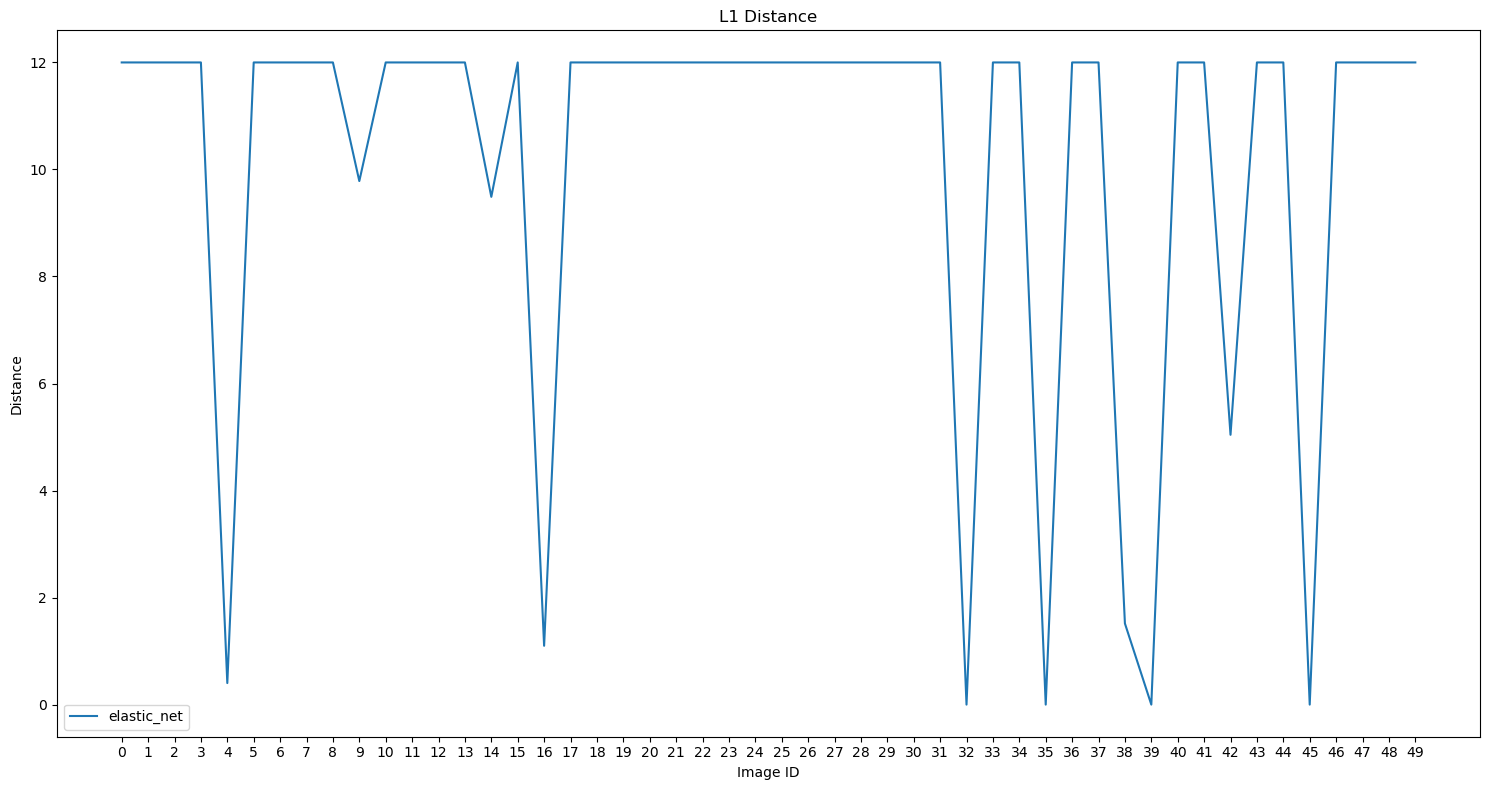

In [ ]:
attack_types_with_distance = [
                'brendel_bethge', #bounded-min
                'pgd_early_stopping', #not-bounded
                'deep_fool', #not-bounded
                'carlini_wagner_l2', #not-bounded
                'elastic_net', #not-bounded
                'elastic_net_L1_rule', #not-bounded
                'elastic_net_L1_rule_higher_beta', #not-bounded
                'exp_attack', #not-bounded
                ]

selected_attack_types_with_distance = [a for a in attack_types if a in attack_types_with_distance]

plt.figure(figsize=(15, 8))
for attack_type in selected_attack_types_with_distance:
  plt.plot(list(range(len(xtest))), results_dict[attack_type]['adversarial_distance'], label=attack_type)
plt.xlabel('Image ID')
plt.ylabel('Distance')
plt.title(f'L{norm} Distance')
plt.legend()
plt.tight_layout()
plt.xticks(list(range(len(xtest))))
plt.show()

# Runtime per image

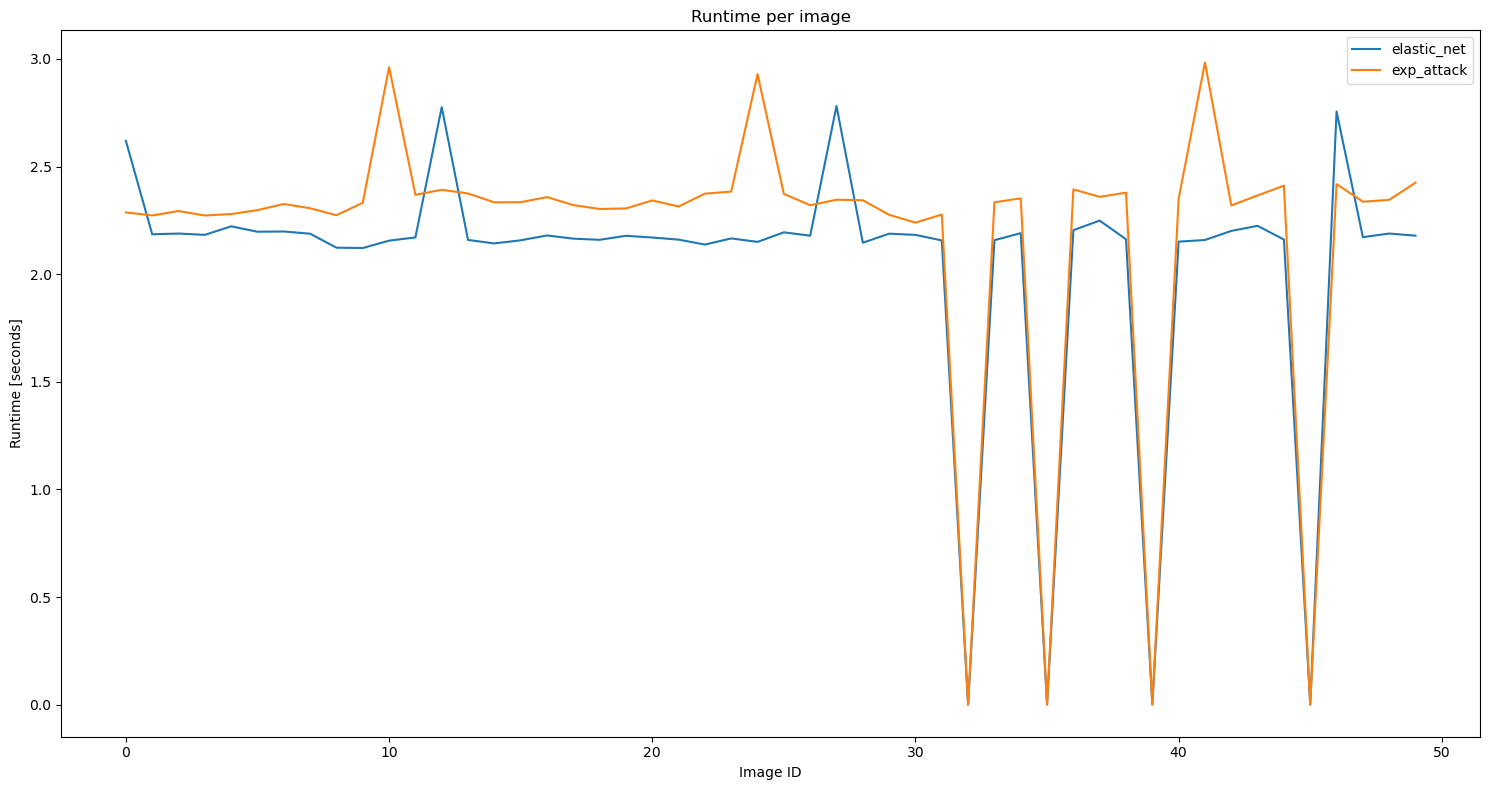

In [52]:
plt.figure(figsize=(15, 8))
for attack_type in attack_types:
  plt.plot(list(range(len(xtest))), results_dict[attack_type]['runtime'], label=attack_type)
plt.xlabel('Image ID')
plt.ylabel('Runtime [seconds]')
plt.title('Runtime per image')
plt.legend()
plt.tight_layout()
plt.show()

## Adversarial Accuracy

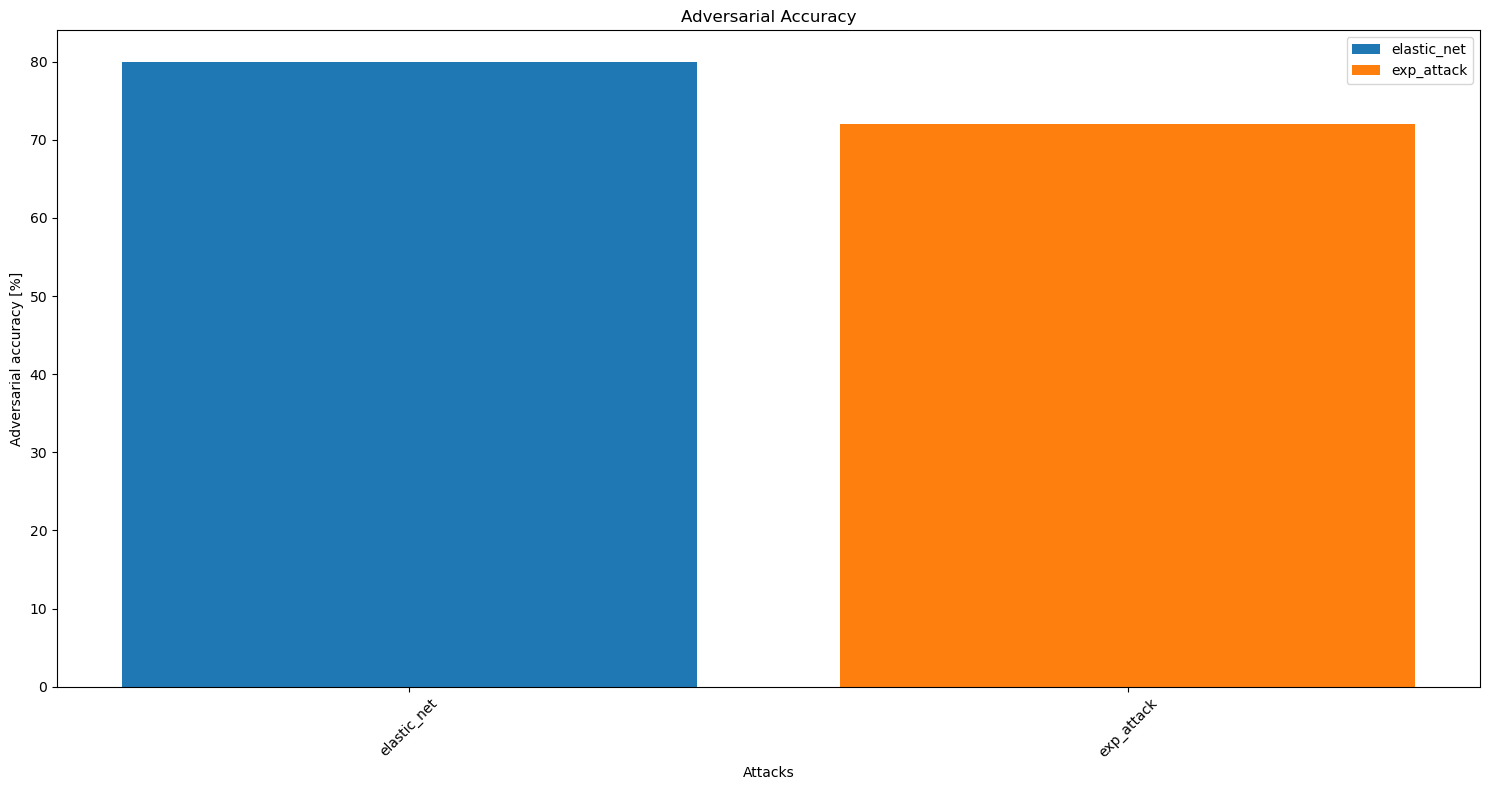

In [53]:
plt.figure(figsize=(15, 8))
for attack_type in attack_types:
  plt.bar(attack_type, results_dict[attack_type]['adversarial_accuracy'], label=attack_type)
plt.xlabel('Attacks')
plt.ylabel('Adversarial accuracy [%]')
plt.xticks(rotation=45)
plt.legend()
plt.title('Adversarial Accuracy')
plt.tight_layout()
plt.show()

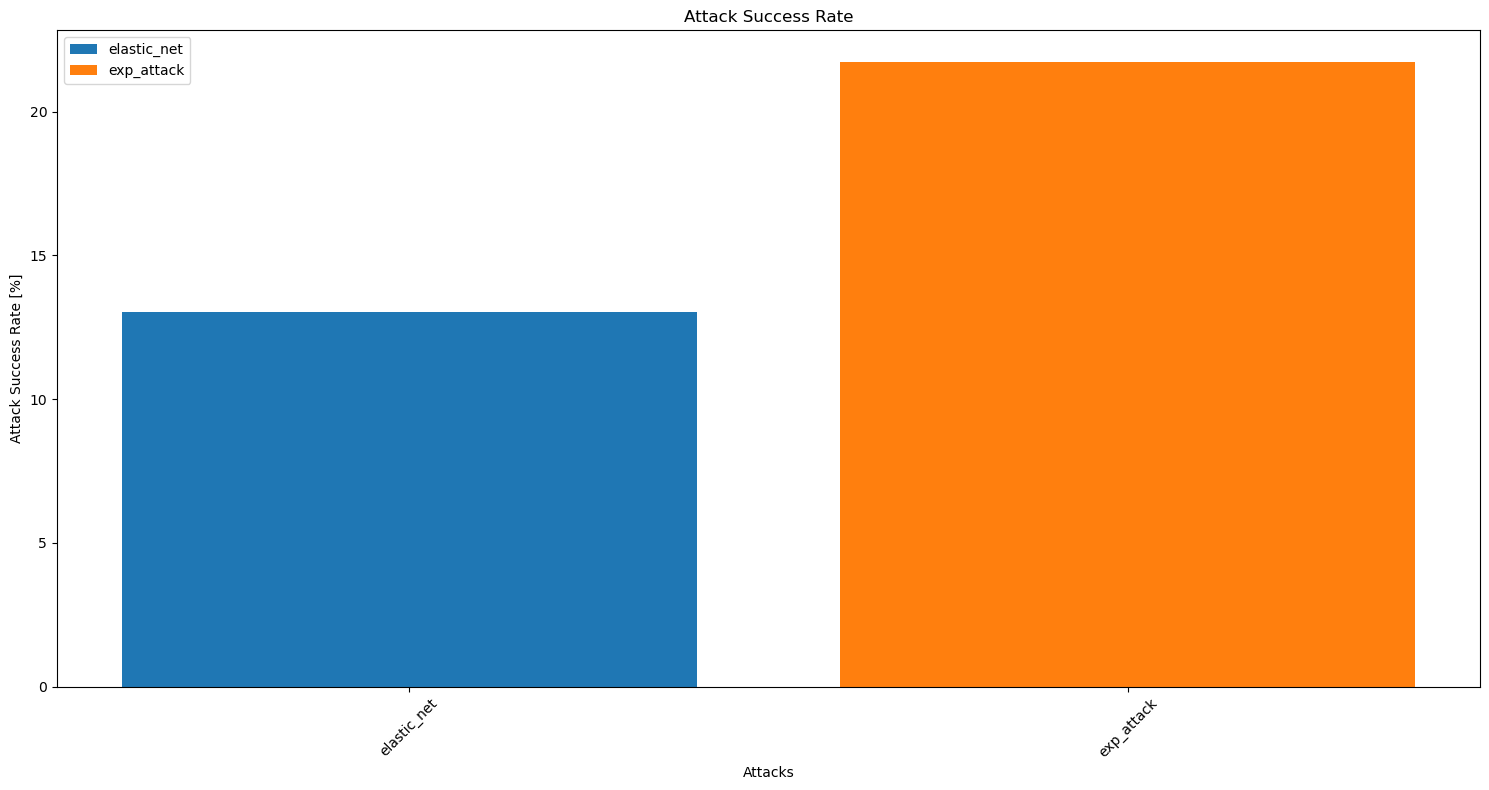

In [54]:
plt.figure(figsize=(15, 8))
for attack_type in attack_types:
  plt.bar(attack_type, results_dict[attack_type]['attack_success_rate'], label=attack_type)
plt.xlabel('Attacks')
plt.ylabel('Attack Success Rate [%]')
plt.xticks(rotation=45)
plt.legend()
plt.title('Attack Success Rate')
plt.tight_layout()
plt.show()

## Total Runtime

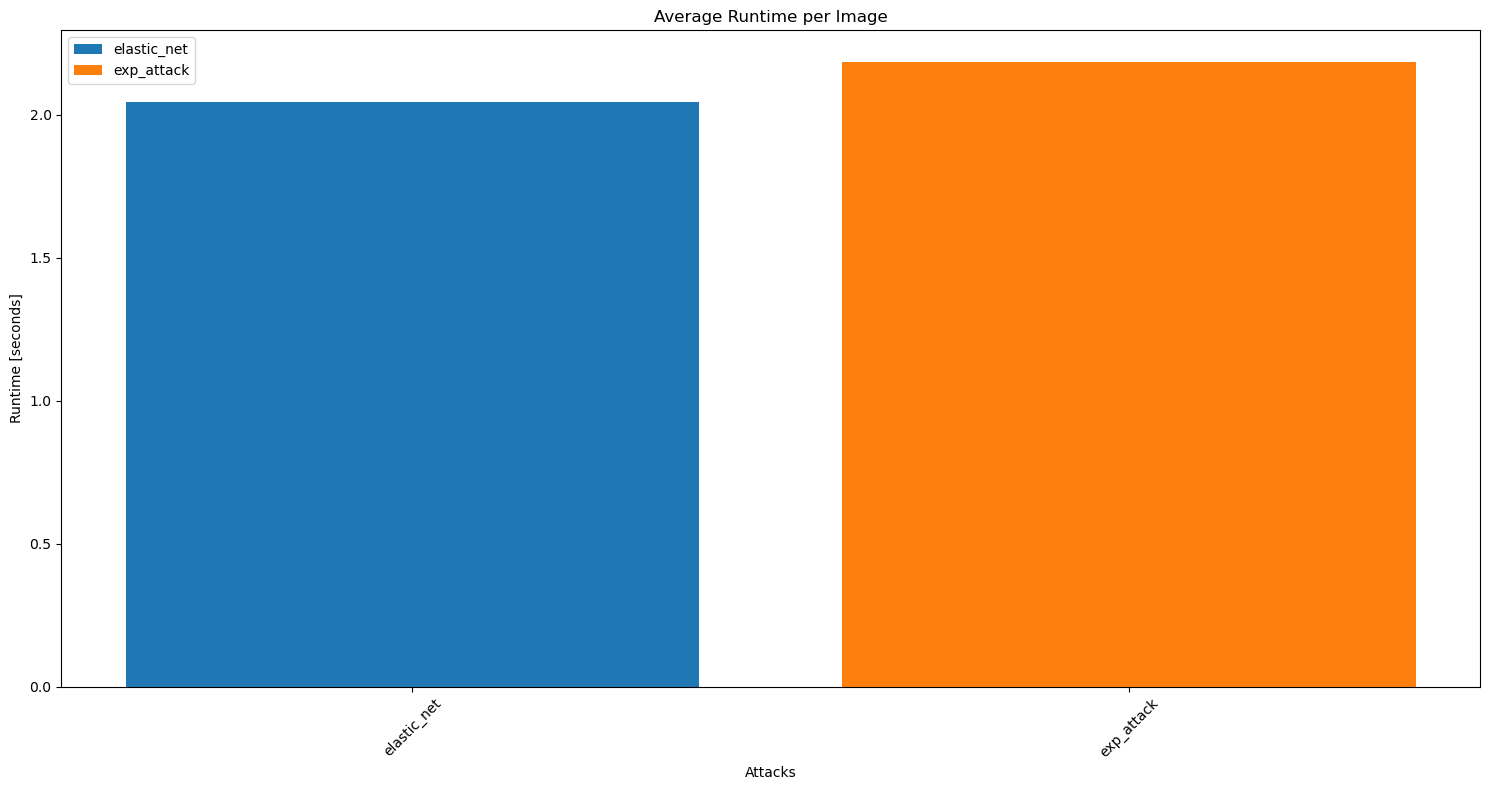

In [55]:
plt.figure(figsize=(15, 8))
for attack_type in attack_types:
  plt.bar(attack_type, sum(results_dict[attack_type]['runtime'])/splitsize, label=attack_type)
plt.xlabel('Attacks')
plt.xticks(rotation=45)
plt.ylabel('Runtime [seconds]')
plt.title('Average Runtime per Image')
plt.legend()
plt.tight_layout()
plt.show()